In [132]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [101]:
df = pd.read_csv('train.csv')

In [102]:
# Helper for manual feature selection
# vars_ = pd.read_csv('vars.csv')
# print(vars_[vars_['type'] == 'ordinal']['name'].tolist())
# print(vars_[vars_['type'] == 'nominal']['name'].tolist())
# print(vars_[vars_['type'] == 'binary']['name'].tolist())
# print(vars_[vars_['type'] == 'continuous']['name'].tolist())
# print(vars_[vars_['type'] == 'discrete']['name'].tolist())
# print(vars_[vars_['type'] == 'date']['name'].tolist())

## Imputing NaN im Numerical Features

In [103]:
#Imputing NA's with 0, as 0 represent no street connected to the lot
df[['LotFrontage']] = df[['LotFrontage']].fillna(0)

## Imputing NaN - Nominal Features

In [104]:
#Electrical
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(df[['Electrical']])
df[['Electrical']] = pd.DataFrame(imp.transform(df[['Electrical']]), columns = ['Electrical'])

#GarageType (impute + convert to binary)
df[['GarageType']] = df[['GarageType']].fillna('N')
df['Garage'] = (df['GarageType'] != 'N').astype(int)

## Rearranging Quantitative features

In [105]:
#Total porch area
df['Total.Porch']= df['OpenPorchSF']+ df['EnclosedPorch'] + df['ScreenPorch']

#Total rooms
df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'] - df['BedroomAbvGr']

#Total baths
df['Total.HalfBath'] = df['BsmtFullBath'] + df['FullBath']
df['Total.FullBath'] = df['BsmtHalfBath'] + df['HalfBath']

# Subtracting num of bedrooms from total number of rooms as bedrooms are represented in a separate feature
df['Total.RmsAbvGrd'] = df['TotRmsAbvGrd'] - df['BedroomAbvGr']

## Converting Nominal Features

In [106]:
#Rename one 'MSZoning' value for dummification
df.loc[(df['MSZoning'] == 'C (all)'), 'MSZoning'] = 'C'

#Converting numerical to categorical
df = df.replace({'MSSubClass': {20: 'SC20', 30: 'SC30', 40: 'SC40', 45: 'SC45', 50: 'SC50', 60: 'SC60', 70: 'SC70', 
                                75: 'SC75', 80: 'SC80', 85: 'SC85', 90: 'SC90', 120: 'SC120', 150: 'SC150', 160: 'SC160',
                                180: 'SC180', 190: 'SC190'} })

## Converting Y/N Features to Binary

In [107]:
#convert CentralAir to boolean
df['CentralAir'] = (df['CentralAir'] != 'N').astype(int)

#convert Fireplaces to boolean
df.loc[(df['Fireplaces'] > 0), 'Fireplaces'] = 1

# Create a binary feature 'Basement' that indicates if the home has a basement
df['Basement'] = [1 if row > 0 else 0 for row in df['TotalBsmtSF']]

# Pool Area
df['PoolArea'] = [1 if row > 0 else 0 for row in df['PoolArea']]

# YearRemodAdd
# if the year listed in both columns is the same, there has not been a renovation
# Turn into binary variable "Reno"
Year_temp = df.YearRemodAdd - df.YearBuilt
df['Reno'] = [0 if x == 0 else 1 for x in Year_temp]

# Conditions 1 + 2
# Only "Positive Feature" really seems to matter here -> binarize
PosFeat1 = [1 if 'Pos' in x else 0 for x in df['Condition1']]
PosFeat1 = pd.Series(PosFeat1)
PosFeat2 = [1 if 'Pos' in x else 0 for x in df['Condition2']]
PosFeat2 = pd.Series(PosFeat2)
temp = pd.DataFrame()
temp['PosFeat1'] = PosFeat1
temp['PosFeat2'] = PosFeat2
temp['PosFeat'] = temp.PosFeat1 + temp.PosFeat2
# binarize and put into df
df['PosFeat'] = [1 if x > 0 else 0 for x in temp['PosFeat']]
# Just in Case:
# Also binarize "Norm" col
# if Cond1 = norm, so does Cond2, so we only need to look @ one col
df['Norm'] = [1 if 'Norm' in x else 0 for x in df['Condition1']]

df['TwoFloors'] = [1 if "2" in x else 0 for x in df['HouseStyle']]
# 1 = the house has 2 floors (or more)
# 0 = the house has 1 floor

df['OneFamHome'] = [1 if row == "1Fam" else 0 for row in df['BldgType']]

df['WoodDeck'] = [1 if row > 0 else 0 for row in df['WoodDeckSF']]

df['Porch'] = [1 if row > 0 else 0 for row in df['Total.Porch']]

# df['LotArea'] = df['LotArea'].apply(fun)

df['LotFrontage'] = [3 if x > 100 else 2 if x > 60 else 1 if x > 0 else 0 for x in df['LotFrontage']]

df['LotArea'] = [2 if x > 12000 else 1 if x > 7000 else 0 for x in df['LotArea']]

## Converting Ordinal Features

In [108]:
quality_scale = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

df = df.replace({'HeatingQC': quality_scale,
                 'KitchenQual': quality_scale,
                 'PavedDrive': {'N': 0, 'Y': 2, 'P': 1},
                 'Functional': {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 
                                'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}
})

## Converting Date Features

In [109]:
# df['YearBuilt'] = pd.DatetimeIndex(df['YearBuilt']).date
# df['YrSold'] = pd.DatetimeIndex(df['YrSold']).date

## Selected Features

In [110]:
ordinal_features = ['PavedDrive', 'Functional', 'OverallQual', 'KitchenQual', 'LotFrontage','HeatingQC', 'LotArea']
nominal_features = ['MSSubClass', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
                    'Neighborhood', 'Electrical', 'SaleCondition', 'MSZoning']
binary_features = ['CentralAir', 'Basement', 'Fireplaces', 'Garage', 'Reno', 'OneFamHome', 
                   'PosFeat', 'Norm', 'TwoFloors', 'PoolArea', 'WoodDeck', 'Porch']
contin_features = ['GrLivArea', 'SalePrice']
discrete_features = ['Total.HalfBath', 'Total.FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars']
date_features = ['YearBuilt', 'YrSold']

## Checking Selected Variables (if in df and data types)

In [111]:
combined_list = ordinal_features+nominal_features+binary_features+contin_features+discrete_features+date_features
print('Number of selected features: ', len(combined_list))
for i in sorted(combined_list):
    print(i, type(df[i][0]))

Number of selected features:  37
Basement <class 'numpy.int64'>
BedroomAbvGr <class 'numpy.int64'>
CentralAir <class 'numpy.int32'>
Electrical <class 'str'>
Fireplaces <class 'numpy.int64'>
Functional <class 'numpy.int64'>
Garage <class 'numpy.int32'>
GarageCars <class 'numpy.int64'>
GrLivArea <class 'numpy.int64'>
HeatingQC <class 'numpy.int64'>
KitchenQual <class 'numpy.int64'>
LandContour <class 'str'>
LandSlope <class 'str'>
LotArea <class 'numpy.int64'>
LotConfig <class 'str'>
LotFrontage <class 'numpy.int64'>
MSSubClass <class 'str'>
MSZoning <class 'str'>
Neighborhood <class 'str'>
Norm <class 'numpy.int64'>
OneFamHome <class 'numpy.int64'>
OverallQual <class 'numpy.int64'>
PavedDrive <class 'numpy.int64'>
PoolArea <class 'numpy.int64'>
Porch <class 'numpy.int64'>
PosFeat <class 'numpy.int64'>
Reno <class 'numpy.int64'>
SaleCondition <class 'str'>
SalePrice <class 'numpy.int64'>
TotRmsAbvGrd <class 'numpy.int64'>
Total.FullBath <class 'numpy.int64'>
Total.HalfBath <class 'numpy.

## Checking for Missingness in Selected Variables

In [112]:
for i in combined_list:
    print(i, df[i].isna().sum())

PavedDrive 0
Functional 0
OverallQual 0
KitchenQual 0
LotFrontage 0
HeatingQC 0
LotArea 0
MSSubClass 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Electrical 0
SaleCondition 0
MSZoning 0
CentralAir 0
Basement 0
Fireplaces 0
Garage 0
Reno 0
OneFamHome 0
PosFeat 0
Norm 0
TwoFloors 0
PoolArea 0
WoodDeck 0
Porch 0
GrLivArea 0
SalePrice 0
Total.HalfBath 0
Total.FullBath 0
BedroomAbvGr 0
TotRmsAbvGrd 0
GarageCars 0
YearBuilt 0
YrSold 0


## Checking Correlation

In [113]:
import matplotlib.pyplot as plt

corr = df[combined_list].corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,PavedDrive,Functional,OverallQual,KitchenQual,LotFrontage,HeatingQC,LotArea,CentralAir,Basement,Fireplaces,Garage,Reno,OneFamHome,PosFeat,Norm,TwoFloors,PoolArea,WoodDeck,Porch,GrLivArea,SalePrice,Total.HalfBath,Total.FullBath,BedroomAbvGr,TotRmsAbvGrd,GarageCars,YearBuilt,YrSold
PavedDrive,1.000000,0.084285,0.229393,0.213023,0.075827,0.157502,0.070422,0.337516,0.137638,0.154082,0.327581,-0.215170,0.009230,0.040516,0.109280,-0.003734,0.020111,0.125783,-0.020800,0.080195,0.231357,0.179088,0.115811,-0.032227,0.016593,0.284598,0.427561,0.006556
Functional,0.084285,1.000000,0.145436,0.107003,0.019020,0.058352,-0.012575,0.091402,0.079304,0.007870,0.063584,-0.104535,-0.005462,0.003218,-0.028782,0.036173,0.016453,0.060794,0.040218,-0.068202,0.107619,0.026341,0.051389,-0.033789,-0.037999,0.086819,0.148792,-0.029805
OverallQual,0.229393,0.145436,1.000000,0.673331,0.201492,0.457083,0.212566,0.272038,0.210177,0.438143,0.261968,-0.080468,0.035872,0.069424,0.099223,0.283999,0.073907,0.274294,0.343575,0.593007,0.790982,0.493116,0.230918,0.101676,0.497400,0.600671,0.572323,-0.027347
KitchenQual,0.213023,0.107003,0.673331,1.000000,0.149248,0.504228,0.171335,0.257830,0.124338,0.291603,0.213937,-0.012616,0.032850,0.042705,0.124077,0.167593,0.066028,0.273506,0.295456,0.420563,0.659600,0.441739,0.150996,-0.018012,0.391552,0.509810,0.530165,0.002047
LotFrontage,0.075827,0.019020,0.201492,0.149248,1.000000,0.121196,0.195454,0.045094,0.019010,0.027104,0.032413,-0.034224,0.154008,-0.053990,0.003111,0.019195,0.061510,0.012690,0.065960,0.181235,0.230982,0.119537,0.002940,0.136969,0.161960,0.180549,0.136900,-0.012449
HeatingQC,0.157502,0.058352,0.457083,0.504228,0.121196,1.000000,0.057379,0.306294,0.128914,0.169052,0.127154,0.014207,0.053658,-0.041995,0.091466,0.134382,-0.041521,0.200841,0.267562,0.254644,0.427649,0.310337,0.087204,-0.026869,0.235723,0.325347,0.448855,-0.009649
LotArea,0.070422,-0.012575,0.212566,0.171335,0.195454,0.057379,1.000000,0.124039,0.006742,0.273637,0.159996,-0.039906,0.406148,0.087953,-0.045701,0.038232,0.074697,0.123028,0.076922,0.393977,0.411714,0.242266,0.119674,0.289486,0.301305,0.305779,0.124224,-0.021652
CentralAir,0.337516,0.091402,0.272038,0.257830,0.045094,0.306294,0.124039,1.000000,0.204832,0.200814,0.251471,-0.176320,0.085294,-0.003606,0.064502,-0.010784,0.018311,0.163894,0.033825,0.093666,0.251328,0.163512,0.139590,0.007872,0.040380,0.233726,0.381831,-0.009420
Basement,0.137638,0.079304,0.210177,0.124338,0.019010,0.128914,0.006742,0.204832,1.000000,0.091777,0.094187,0.031747,0.116622,0.022548,0.037157,0.072621,0.011192,0.102197,0.142015,0.069417,0.152829,0.081262,0.128228,0.005655,0.014534,0.078075,0.078510,-0.028943
Fireplaces,0.154082,0.007870,0.438143,0.291603,0.027104,0.169052,0.273637,0.200814,0.091777,1.000000,0.202086,0.035521,0.124285,0.112363,0.005903,0.151115,0.065705,0.206934,0.205328,0.445299,0.471908,0.274431,0.217703,0.105721,0.366450,0.349501,0.221006,-0.049736


In [114]:
#Initial complete dataset
df1 = pd.read_csv('train.csv')
corr1 = df1.corr()
corr1.style.background_gradient(cmap='coolwarm', axis=None)

## Preparing data for the model
### Dummify:
nominal_features

### Normalize:
contin_features

### Keep as is
discrete_features,
date_features,
ordinal_features,
binary_features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6976797F0>,
      dtype=object)

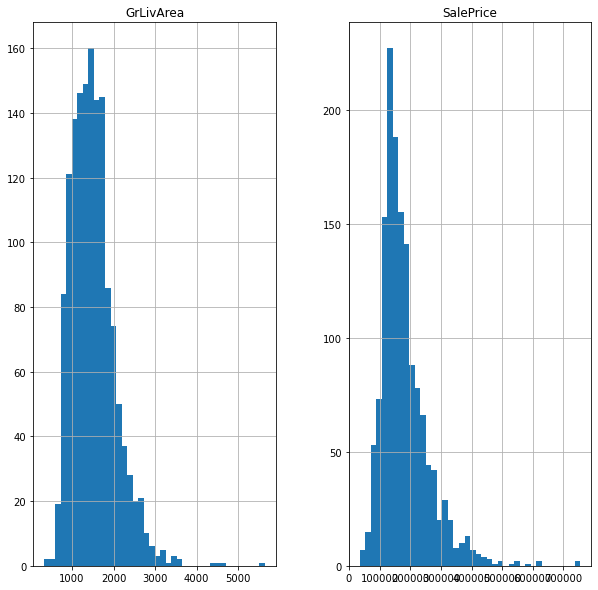

In [115]:
df[contin_features].hist(bins = 40, figsize = (10, 10))
# contin_features

### Log Transform GrLivArea, SalePrice

In [116]:
df['GrLivArea'] = df['GrLivArea'].apply(lambda x: np.log(x))
df['SalePrice'] = df['SalePrice'].apply(lambda x: np.log(x))

In [117]:
# x = pd.get_dummies(df[nominal_features], prefix= 'XXX', drop_first=True)
# x

In [118]:
nominal_dummies = df[nominal_features]
nominal_dummies = pd.get_dummies(testdf, drop_first=True)

In [119]:
ordinal_features = ['PavedDrive', 'Functional', 'OverallQual', 'KitchenQual', 'LotFrontage','HeatingQC', 'LotArea']
nominal_features = ['MSSubClass', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
                    'Neighborhood', 'Electrical', 'SaleCondition', 'MSZoning']
binary_features = ['CentralAir', 'Basement', 'Fireplaces', 'Garage', 'Reno', 'OneFamHome', 
                   'PosFeat', 'Norm', 'TwoFloors', 'PoolArea', 'WoodDeck', 'Porch']
contin_features = ['GrLivArea', 'SalePrice']
discrete_features = ['Total.HalfBath', 'Total.FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars']
date_features = ['YearBuilt', 'YrSold']

In [120]:
selection = ordinal_features+binary_features+contin_features+discrete_features+date_features
final_data = df[selection]

# Final data

In [121]:
final_data = pd.concat([final_data, nominal_dummies], axis = 1)
final_data

,PavedDrive,Functional,OverallQual,KitchenQual,LotFrontage,HeatingQC,LotArea,CentralAir,Basement,Fireplaces,...,Electrical_SBrkr,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,2,8,7,4,2,5,1,1,1,0,...,1,0,0,0,1,0,0,0,1,0
1,2,8,6,3,2,5,1,1,1,1,...,1,0,0,0,1,0,0,0,1,0
2,2,8,7,4,2,5,1,1,1,1,...,1,0,0,0,1,0,0,0,1,0
3,2,8,7,4,1,4,1,1,1,1,...,1,0,0,0,0,0,0,0,1,0
4,2,8,8,4,2,5,2,1,1,1,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,8,6,3,2,5,1,1,1,1,...,1,0,0,0,1,0,0,0,1,0
1456,2,7,6,3,2,3,2,1,1,1,...,1,0,0,0,1,0,0,0,1,0
1457,2,8,7,4,2,5,1,1,1,1,...,1,0,0,0,1,0,0,0,1,0
1458,2,8,5,4,2,4,1,1,1,0,...,0,0,0,0,1,0,0,0,1,0


In [133]:
final_data.to_csv('final_data.csv')

In [122]:
final_data.columns

Index(['PavedDrive', 'Functional', 'OverallQual', 'KitchenQual', 'LotFrontage',
       'HeatingQC', 'LotArea', 'CentralAir', 'Basement', 'Fireplaces',
       'Garage', 'Reno', 'OneFamHome', 'PosFeat', 'Norm', 'TwoFloors',
       'PoolArea', 'WoodDeck', 'Porch', 'GrLivArea', 'SalePrice',
       'Total.HalfBath', 'Total.FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'GarageCars', 'YearBuilt', 'YrSold', 'MSSubClass_SC160',
       'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC20',
       'MSSubClass_SC30', 'MSSubClass_SC40', 'MSSubClass_SC45',
       'MSSubClass_SC50', 'MSSubClass_SC60', 'MSSubClass_SC70',
       'MSSubClass_SC75', 'MSSubClass_SC80', 'MSSubClass_SC85',
       'MSSubClass_SC90', 'LandContour_HLS', 'LandContour_Low',
       'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod',
       'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Nei

In [127]:
ss = StandardScaler()

In [128]:
training_scale = ss.fit(final_data)

In [131]:
final_data_ss = training_scale.transform(final_data)
final_data_ss

array([[ 0.28974476,  0.23704355,  0.65147924, ..., -0.10526316,
         0.51813339, -0.41895507],
       [ 0.28974476,  0.23704355, -0.07183611, ..., -0.10526316,
         0.51813339, -0.41895507],
       [ 0.28974476,  0.23704355,  0.65147924, ..., -0.10526316,
         0.51813339, -0.41895507],
       ...,
       [ 0.28974476,  0.23704355,  0.65147924, ..., -0.10526316,
         0.51813339, -0.41895507],
       [ 0.28974476,  0.23704355, -0.79515147, ..., -0.10526316,
         0.51813339, -0.41895507],
       [ 0.28974476,  0.23704355, -0.79515147, ..., -0.10526316,
         0.51813339, -0.41895507]])

In [ ]:
train_x , test_x, train_y, test_y = train_test_split(x, y, test_size=.2, random_state=0, stratify=y)